In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

dataset=pd.read_csv('/content/sample_data/extra.csv', sep=",")

# Supprimer les lignes où la colonne 'TARGET' contient des NaN
dataset_coherent = dataset.dropna(subset=['TARGET'])

# Suppression des lignes où la valeur de 'HEIGHT3' commence par un '9'
dataset_coherent = dataset_coherent[~dataset_coherent['HEIGHT3'].astype(str).str.startswith('9')]

# Supprimer les deux dernières colonnes
dataset_explicatif=dataset_coherent.drop(columns=['TARGET', 'ID'])


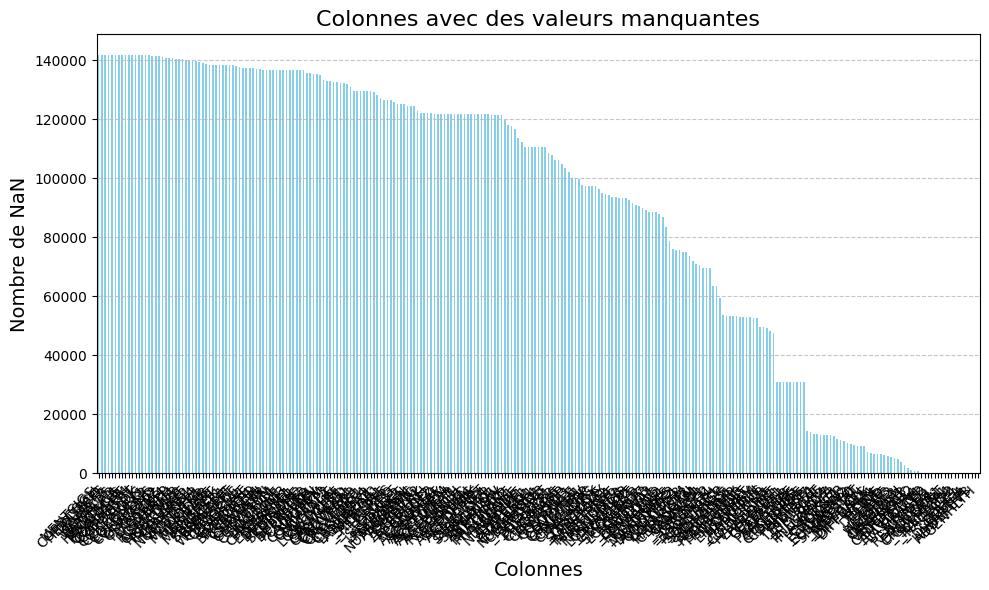

In [6]:
#Identification des colonnes avec le plus de valeurs manquantes

# 1. Supprimer les colonnes qui ne contiennent que des NaN
dataset_explicatif_cleaned = dataset_explicatif.dropna(axis=1, how='all')

# 2. Calcul du nombre de valeurs manquantes par colonne
nan_counts = dataset_explicatif.isna().sum()

# 3. Filtrer les colonnes avec au moins une valeur manquante et trier par ordre décroissant
nan_counts_sorted = nan_counts[nan_counts > 0].sort_values(ascending=False)

# 4. Stocker dans une nouvelle variable
columns_with_nan = nan_counts_sorted

# 5. Visualisation
plt.figure(figsize=(10, 6))
columns_with_nan.plot(kind='bar', color='skyblue')
plt.title("Colonnes avec des valeurs manquantes", fontsize=16)
plt.xlabel("Colonnes", fontsize=14)
plt.ylabel("Nombre de NaN", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [7]:
#Suppression des colonnes avec le plus de valeurs manquantes

# 1. Identifier les colonnes avec plus de 20 000 valeurs manquantes
columns_to_drop = columns_with_nan[columns_with_nan > 20000].index

# 2. Supprimer ces colonnes du jeu de données
dataset_cleaned = dataset_explicatif.drop(columns=columns_to_drop)
print(len(dataset_cleaned.columns))

# 3. Afficher les colonnes supprimées pour vérification
print(f"Colonnes supprimées : {list(columns_to_drop)}")
print(f"Colonnes conservées : {list(dataset_cleaned.columns)}")
print(f"Dimensions initiales du dataset : {dataset.shape}")
print(f"Dimensions après suppression : {dataset_cleaned.shape}")


112
Colonnes supprimées : ['MENTCIGS', 'COPDCOGH', 'HEATTBCO', 'TOLDCFS', 'HAVECFS', 'WORKCFS', 'IMFVPLA3', 'HPVADVC4', 'MENTECIG', 'HPVADSHT', 'COPDFLEM', 'COPDBRTH', 'COPDBTST', 'COPDSMOK', 'COLGHOUS', 'COLGSEX1', 'LOADULK2', 'CCLGHOUS', 'GUNLOAD', 'CSRVCTL2', 'FIREARM5', 'LASTSIG4', 'CDHELP', 'RCSXBRTH', 'USEMRJN4', 'CASTHNO2', 'NOBCUSE8', 'PSASUGST', 'PCPSARS2', 'PSATIME1', 'NUMPHON4', 'VCLNTES2', 'PCSTALK1', 'MARJOTHR', 'MARJDAB', 'MARJVAPE', 'MARJEAT', 'MARJSMOK', 'PSATEST1', 'SDNATES1', 'BLDSTFIT', 'CSRVINST', 'WHEREGET', 'CDDISCUS', 'CDSOCIAL', 'CDASSIST', 'CDHOUSE', 'BRTHCNT4', 'TYPCNTR9', 'CSRVCLIN', 'CSRVDEIN', 'CSRVINSR', 'CSRVRTRN', 'CSRVSUM', 'CSRVDOC1', 'DIABTYPE', 'INSULIN1', 'CHKHEMO3', 'EYEEXAM1', 'DIABEYE1', 'DIABEDU1', 'FEETSORE', 'STOPSMK2', 'SHINGLE2', 'BCPREFER', 'PFPPRVN4', 'CSRVPAIN', 'HADSEX', 'COVIDPRM', 'CSRVTRT3', 'CNCRTYP2', 'CNCRAGE', 'LCSCTWHN', 'CNCRDIFF', 'SIGMTES1', 'CRGVALZD', 'CRGVHOU1', 'CRGVPER1', 'CRGVPRB3', 'CRGVHRS1', 'CRGVLNG1', 'CRGVREL4', 'C

In [8]:
# Suppression des colonnes évidemment inutiles

colonnes_a_enlever = ['FMONTH','IDATE', 'IYEAR', 'IMONTH', 'IDAY', 'DISPCODE']
dataset_cleaned = dataset_cleaned.drop(columns=colonnes_a_enlever)

print(dataset_cleaned)

# Vérification
print(f"Colonnes supprimées : {colonnes_a_enlever}")
print(f"Colonnes restantes : {list(dataset_cleaned.columns)}")
print(f"Nombre de colonnes restantes : {len(dataset_cleaned.columns)}")
print(f"Dimensions après suppression : {dataset_cleaned.shape}")

        _STATE       SEQNO          _PSU  SEXVAR  GENHLTH  PHYSHLTH  MENTHLTH  \
0         39.0  2022015087  2.022015e+09     2.0      3.0       5.0       2.0   
1         39.0  2022015088  2.022015e+09     1.0      4.0      21.0      30.0   
2         39.0  2022015089  2.022015e+09     1.0      2.0      88.0      88.0   
3         39.0  2022015090  2.022015e+09     2.0      2.0      88.0      88.0   
5         39.0  2022015092  2.022015e+09     1.0      2.0       2.0       5.0   
...        ...         ...           ...     ...      ...       ...       ...   
145127    78.0  2022001527  2.022002e+09     2.0      3.0      88.0       3.0   
145128    78.0  2022001528  2.022002e+09     2.0      1.0       2.0       2.0   
145129    78.0  2022001529  2.022002e+09     2.0      5.0      30.0      30.0   
145130    78.0  2022001530  2.022002e+09     1.0      2.0      88.0      88.0   
145131    78.0  2022001531  2.022002e+09     1.0      2.0      88.0       1.0   

        PRIMINSR  PERSDOC3 

In [9]:
# Sélectionner uniquement les colonnes numériques
dataset_cleaned = dataset_cleaned.select_dtypes(include=['number'])

# Remplacer les NaN par la moyenne de chaque colonne numérique
dataset_cleaned = dataset_cleaned.fillna(dataset_cleaned.mean())

# Vérifier s'il y a encore des NaN dans le dataset
nan_count = dataset_cleaned.isna().sum()

# Afficher le nombre de NaN par colonne
print(nan_count)

# Vérifier s'il reste des NaN dans le DataFrame
if nan_count.sum() == 0:
    print("Il n'y a plus de NaN dans le jeu de données.")
else:
    print(f"Il reste encore {nan_count.sum()} NaN dans le jeu de données.")

_STATE      0
SEQNO       0
_PSU        0
SEXVAR      0
GENHLTH     0
           ..
DROCDY4_    0
_RFBING6    0
_DRNKWK2    0
_RFDRHV8    0
_AIDTST4    0
Length: 106, dtype: int64
Il n'y a plus de NaN dans le jeu de données.


In [12]:
# Calculer la matrice de corrélation
correlation_matrix = dataset_cleaned.corr()

# Seuil de corrélation pour considérer que les variables sont trop corrélées
correlation_threshold = 0.9

# Identifier les variables à supprimer en ne gardant qu'une seule par groupe fortement corrélé
to_drop = set()  # Ensemble des variables à supprimer
selected = set()  # Ensemble des variables gardées

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        # Vérifier si la corrélation absolue dépasse le seuil
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            col_i = correlation_matrix.columns[i]
            col_j = correlation_matrix.columns[j]

            # Si aucune des variables n'est déjà dans `selected`, en garder une et marquer l'autre
            if col_i not in selected and col_j not in selected:
                selected.add(col_j)  # Garder une seule variable (col_j par exemple)
                to_drop.add(col_i)  # Supprimer l'autre (col_i)
            elif col_i in selected:
                to_drop.add(col_j)  # Si col_i est déjà gardée, supprimer col_j
            elif col_j in selected:
                to_drop.add(col_i)  # Si col_j est déjà gardée, supprimer col_i

# Afficher les variables à supprimer et celles conservées
print(f"Variables conservées : {list(selected)}")
print(f"Variables supprimées : {list(to_drop)}")

# Enlever les variables fortement corrélées
dataset_cleaned = dataset_cleaned.drop(columns=to_drop)

# Afficher le nombre de colonnes restantes
print(f"Nombre de colonnes restantes : {len(dataset_cleaned.columns)}")



Variables conservées : []
Variables supprimées : []
Nombre de colonnes restantes : 40


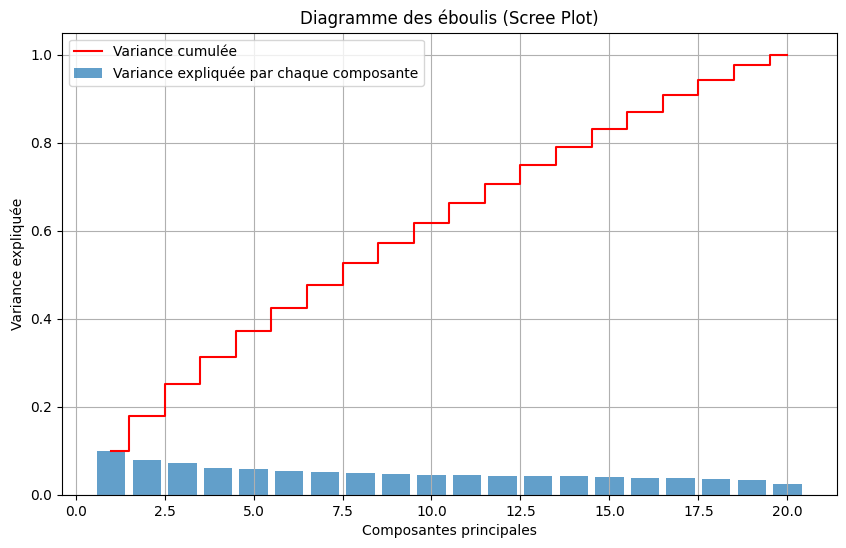

Les 20 variables les plus importantes :
Index(['PHYSHLTH', 'ADDEPEV3', 'FLUSHOT7', 'SMOKE100', 'RENTHOM1', 'ALCDAY4',
       '_PHYS14D', '_MENT14D', 'COVIDPOS', 'DECIDE', 'VETERAN3', 'DIFFDRES',
       'EDUCA', 'HTIN4', 'MENTHLTH', 'HIVRISK5', 'TETANUS1', 'PNEUVAC4',
       '_HISPANC', 'EMPLOY1'],
      dtype='object')
Nombre de variables sélectionnées : 20
Nombre de colonnes restantes après sélection : 20


In [17]:
# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset_cleaned)

# Appliquer l'ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée par chaque composante
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Afficher le diagramme des éboulis
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Variance expliquée par chaque composante')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Variance cumulée', color='red')
plt.xlabel('Composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Diagramme des éboulis (Scree Plot)')
plt.legend(loc='best')
plt.grid()
plt.show()

# Identifier le nombre de composantes qui expliquent le plus de variance
# Nous voulons maintenant sélectionner les 40 premières variables les plus importantes
n_top_variables = 20  # Nombre de variables à conserver

# Récupérer les poids (charges) de chaque variable pour toutes les composantes principales
components = pca.components_

# Calculer l'importance de chaque variable en fonction de son poids dans toutes les composantes
# Les variables avec les plus grands poids (en valeur absolue) sont les plus importantes
importance = np.abs(components).sum(axis=0)

# Obtenir les indices des 40 variables les plus importantes
top_indices = np.argsort(importance)[::-1][:n_top_variables]

# Récupérer les noms des variables correspondantes
top_variables = dataset_cleaned.columns[top_indices]

# Afficher les variables les plus importantes
print("Les 20 variables les plus importantes :")
print(top_variables)
print(f"Nombre de variables sélectionnées : {len(top_variables)}")

# Conserver uniquement les 40 variables les plus importantes dans le dataset
dataset_cleaned = dataset_cleaned[top_variables]

# Afficher le nombre de colonnes restantes après réduction
print(f"Nombre de colonnes restantes après sélection : {len(dataset_cleaned.columns)}")


In [ ]:
# Méthode Elastic-Net

# 1. Séparation des données en caractéristiques (X) et variable cible (y)
X = dataset_cleaned
y = dataset_coherent['TARGET']

# 2. Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3. Initialisation et entraînement du modèle Elastic-Net
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)  # Vous pouvez ajuster alpha et l1_ratio
elastic_net.fit(X_train, y_train)

# 4. Prédictions
y_pred_train = elastic_net.predict(X_train)
y_pred_test = elastic_net.predict(X_test)

# 5. Évaluation du modèle
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train MSE: {mse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.4f}, R2: {r2_test:.4f}")



In [18]:
# Méthode SHAP

# 1. Séparation des données en caractéristiques (X) et variable cible (y)
X = dataset_cleaned
y = dataset_coherent['TARGET']

# 2. Séparer les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# 3. Utilisez un sous-ensemble de 5000 lignes au lieu de 116 000
X_train_sample = X_train.sample(n=5000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# 4. Entraîner un modèle RandomForest sur l'échantillon
model = RandomForestClassifier(n_estimators=50, random_state=50)  # Réduire le nombre d'arbres pour gagner en vitesse
model.fit(X_train_sample, y_train_sample)

# 5. Sélectionner un sous-ensemble du jeu de test pour l'analyse SHAP
X_test_sample = X_test.sample(n=1000, random_state=42)

# 6. Créer un explainer SHAP pour ce modèle
explainer = shap.TreeExplainer(model)

assert list(X_train_sample.columns) == list(X_test_sample.columns), "Les colonnes de X_train et X_test ne correspondent pas !"
X_test_sample = X_test_sample[X_train_sample.columns]

# 7. Calculer les valeurs SHAP pour le sous-ensemble
shap_values = explainer.shap_values(X_test_sample)

# 8. Visualiser l'importance des variables avec un graphique SHAP summary_plot
shap.summary_plot(shap_values[1], X_test_sample, plot_type="bar")  # Classe 1 (pour problème binaire)

# 9. Visualiser les contributions des variables pour une instance spécifique
shap.initjs()  # Activer les visualisations interactives
